<a href="https://colab.research.google.com/github/obeabi/DeepLearning/blob/master/RegularizationOnNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Written by : Abiola Obembe
## Date      : 24-08-2020
### Objective : Effect of regularization and dropout on Neural Network model performance

In [41]:
# Install packages
import numpy as np
import pandas as pd
from reg_utils import  *
from testCases import *
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

print("packages installed!")


packages installed!


## Load dataset and perform exploratory analysis

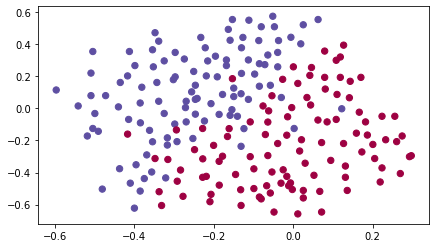

In [42]:
# load dataset and perform exploratory analysis
train_X, train_Y, test_X, test_Y = load_2D_dataset()

In [43]:
# examine training dataset
print("The shape of the training set X is" , train_X.shape)
print("The shape of the training set for target variable Y is" , train_Y.shape)
print("The number of training examples is"  '  '+ str(train_X.shape[1]))
# print the first three training examples
print(train_X[:,0:3])
print(train_Y[:,0:3])

The shape of the training set X is (2, 211)
The shape of the training set for target variable Y is (1, 211)
The number of training examples is  211
[[-0.158986 -0.347926 -0.504608]
 [ 0.423977  0.47076   0.353801]]
[[1 1 1]]


In [44]:
# examine test dataset
print("The shape of the test set X is" , test_X.shape)
print("The shape of the test set for target variable Y is" , test_Y.shape)
print("The number of test examples is"  '  '+ str(test_X.shape[1]))
# print the first three test examples
print(test_X[:,0:3])
print(test_Y[:,0:3])

The shape of the test set X is (2, 200)
The shape of the test set for target variable Y is (1, 200)
The number of test examples is  200
[[-0.35306235 -0.2271258   0.09289767]
 [-0.67390181  0.44731976 -0.75352419]]
[[0 1 0]]


## Non-regularized NN Model

In [45]:
def model(X, Y, learning_rate = 0.3, num_iterations = 30000, print_cost = True, lambd = 0, keep_prob = 1):
    """
    Implements a three-layer neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (output size, number of examples)
    learning_rate -- learning rate of the optimization
    num_iterations -- number of iterations of the optimization loop
    print_cost -- If True, print the cost every 10000 iterations
    lambd -- regularization hyperparameter, scalar
    keep_prob - probability of keeping a neuron active during drop-out, scalar.
    
    Returns:
    parameters -- parameters learned by the model. They can then be used to predict.
    """
        
    grads = {}
    costs = []                            # to keep track of the cost
    m = X.shape[1]                        # number of examples
    layers_dims = [X.shape[0], 20, 3, 1]  # 3-Layer NN archtecture 
    
    # Initialize parameters dictionary.
    parameters = initialize_parameters(layers_dims)

    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
        if keep_prob == 1:
            a3, cache = forward_propagation(X, parameters)
        elif keep_prob < 1:
            a3, cache = forward_propagation_with_dropout(X, parameters, keep_prob)
        
        # Cost function
        if lambd == 0:
            cost = compute_cost(a3, Y)
        else:
            cost = compute_cost_with_regularization(a3, Y, parameters, lambd)
            
        # Backward propagation.
        assert(lambd==0 or keep_prob==1)    # it is possible to use both L2 regularization and dropout, 
                                            # but this assignment will only explore one at a time
        if lambd == 0 and keep_prob == 1:
            grads = backward_propagation(X, Y, cache)
        elif lambd != 0:
            grads = backward_propagation_with_regularization(X, Y, cache, lambd)
        elif keep_prob < 1:
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print the loss every 10000 iterations
        if print_cost and i % 10000 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
        if print_cost and i % 1000 == 0:
            costs.append(cost)
    
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (x1,000)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

### Train and make predictions from the model

Cost after iteration 0: 0.6557412523481002
Cost after iteration 10000: 0.1632998752572417
Cost after iteration 20000: 0.13851642423284755


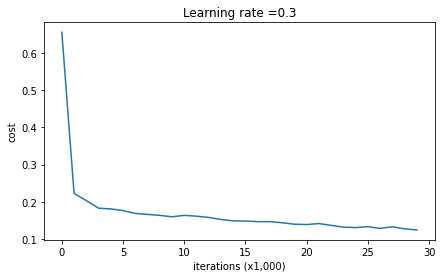

In [46]:
# Train neural network model
parameters = model(train_X, train_Y)

In [47]:
# Examine model performance on train and test set
print ("On the training set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

On the training set:
Accuracy: 0.9478672985781991
On the test set:
Accuracy: 0.915


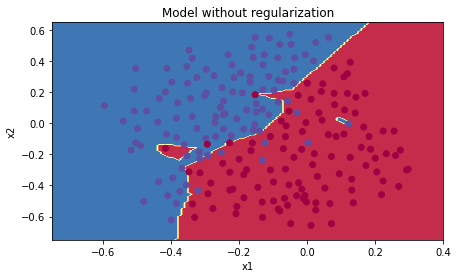

In [48]:
# Plot decision boundary
plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
#plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

### Comment: There seems to be some occurence of overfitting as test set accuracy is somewhat greater than training set accuracy. In addition, there seems to be much flexibility in the boundary

## Regularized NN Model: L2 Regularization

In [49]:
# FUNCTION: compute_cost_with_regularization

def compute_cost_with_regularization(A3, Y, parameters, lambd):
    """
    Implement the cost function with L2 regularization.
    
    Arguments:
    A3 -- post-activation, output of forward propagation, of shape (output size, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    parameters -- python dictionary containing parameters of the model
    
    Returns:
    cost - value of the regularized loss function (formula (2))
    """
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    
    cross_entropy_cost = compute_cost(A3, Y) # This gives you the cross-entropy part of the cost
    
    L2_regularization_cost = np.sum( [np.sum(np.square(W1)), np.sum(np.square(W2)), np.sum(np.square(W3))]) * (lambd/ (2*m))   
    
    cost = cross_entropy_cost + L2_regularization_cost
    
    return cost

In [50]:
# test code above
A3, Y_assess, parameters = compute_cost_with_regularization_test_case()

print("cost = " + str(compute_cost_with_regularization(A3, Y_assess, parameters, lambd = 0.1)))

cost = 1.7864859451590758


In [56]:
# FUNCTION: backward_propagation_with_regularization

def backward_propagation_with_regularization(X, Y, cache, lambd):
    """
    Implements the backward propagation of our baseline model to which we added an L2 regularization.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    cache -- cache output from forward_propagation()
    lambd -- regularization hyperparameter, scalar
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 -Y
    dW3 = 1/m * np.dot(dZ3, A2.T) + np.multiply(lambd/m , W3)
    db3 = 1/m * np.sum( dZ3, axis = 1, keepdims= True)
    dA2 = np.dot(W3.T, dZ3) 
    dZ2 = np.multiply(dA2, np.int64(A2>0))
    dW2 = 1/m * np.dot(dZ2, A1.T) + np.multiply(lambd/m , W2)
    db2 =1/m * np.sum( dZ2, axis = 1, keepdims= True)
    dA1 = np.dot(W2.T, dZ2) 
    dZ1 = np.multiply(dA1,np.int64(A1>0))
    dW1 = 1/m * np.dot(dZ1, X.T) + np.multiply(lambd/m , W1)
    db1 = 1/m * np.sum( dZ1, axis = 1, keepdims= True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [57]:
# Test code above
X_assess, Y_assess, cache = backward_propagation_with_regularization_test_case()

grads = backward_propagation_with_regularization(X_assess, Y_assess, cache, lambd = 0.7)
print ("dW1 = \n"+ str(grads["dW1"]))
print ("dW2 = \n"+ str(grads["dW2"]))
print ("dW3 = \n"+ str(grads["dW3"]))

dW1 = 
[[-0.25604646  0.12298827 -0.28297129]
 [-0.17706303  0.34536094 -0.4410571 ]]
dW2 = 
[[ 0.79276486  0.85133918]
 [-0.0957219  -0.01720463]
 [-0.13100772 -0.03750433]]
dW3 = 
[[-1.77691347 -0.11832879 -0.09397446]]


### Train and make predictions from model

Cost after iteration 0: 0.6974484493131264
Cost after iteration 10000: 0.2684918873282239
Cost after iteration 20000: 0.2680916337127301


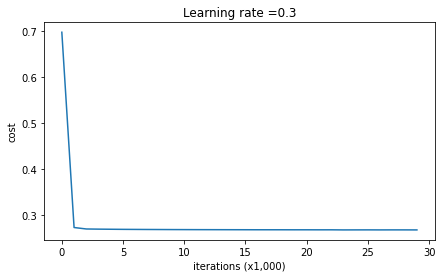

In [58]:
# train NN
parameters = model(train_X, train_Y, lambd = 0.7)


In [60]:
# Evauate Model accuracy
print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

On the train set:
Accuracy: 0.9383886255924171
On the test set:
Accuracy: 0.93


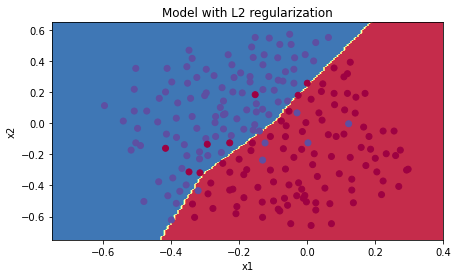

In [62]:
# Plot decision boundary
plt.title("Model with L2 regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

## Dropout Regularization

In [63]:
 #FUNCTION: forward_propagation_with_dropout

def forward_propagation_with_dropout(X, parameters, keep_prob = 0.5):
    """
    Implements the forward propagation: LINEAR -> RELU + DROPOUT -> LINEAR -> RELU + DROPOUT -> LINEAR -> SIGMOID.
    
    Arguments:
    X -- input dataset, of shape (2, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3":
                    W1 -- weight matrix of shape (20, 2)
                    b1 -- bias vector of shape (20, 1)
                    W2 -- weight matrix of shape (3, 20)
                    b2 -- bias vector of shape (3, 1)
                    W3 -- weight matrix of shape (1, 3)
                    b3 -- bias vector of shape (1, 1)
    keep_prob - probability of keeping a neuron active during drop-out, scalar
    
    Returns:
    A3 -- last activation value, output of the forward propagation, of shape (1,1)
    cache -- tuple, information stored for computing the backward propagation
    """
    
    np.random.seed(1)
    
    # retrieve parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1) 
    D1 = np.random.rand(A1.shape[0], A1.shape[1])     # Step 1: initialize matrix D1 = np.random.rand(..., ...)
    D1 =(D1 < keep_prob ).astype(int)                 # Step 2: convert entries of D1 to 0 or 1 (using keep_prob as the threshold)
    A1 = np.multiply(A1,D1)                           # Step 3: shut down some neurons of A1
    A1 = np.divide(A1,keep_prob)                      # Step 4: scale the value of neurons that haven't been shut down
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    D2 = np.random.rand(A2.shape[0], A2.shape[1])    # Step 1: initialize matrix D2 = np.random.rand(..., ...)
    D2 =  (D2 < keep_prob ).astype(int)              # Step 2: convert entries of D2 to 0 or 1 (using keep_prob as the threshold)
    A2 =  np.multiply(A2,D2)                         # Step 3: shut down some neurons of A2
    A2 = np.divide(A2,keep_prob)                                        # Step 4: scale the value of neurons that haven't been shut down
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    
    cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)
    
    return A3, cache

In [64]:
# test code above
X_assess, parameters = forward_propagation_with_dropout_test_case()

A3, cache = forward_propagation_with_dropout(X_assess, parameters, keep_prob = 0.7)
print ("A3 = " + str(A3))

A3 = [[0.36974721 0.00305176 0.04565099 0.49683389 0.36974721]]


In [65]:
# FUNCTION: backward_propagation_with_dropout

def backward_propagation_with_dropout(X, Y, cache, keep_prob):
    """
    Implements the backward propagation of our baseline model to which we added dropout.
    
    Arguments:
    X -- input dataset, of shape (2, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    cache -- cache output from forward_propagation_with_dropout()
    keep_prob - probability of keeping a neuron active during drop-out, scalar
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    
    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T)
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    dA2 = np.dot(W3.T, dZ3)
    dA2 = np.multiply(dA2,D2)        # Step 1: Apply mask D2 to shut down the same neurons as during the forward propagation
    dA2 = np.divide(dA2,keep_prob)  # Step 2: Scale the value of neurons that haven't been shut down
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    dA1 = np.dot(W2.T, dZ2)
    dA1 = np.multiply(dA1,D1)   # Step 1: Apply mask D1 to shut down the same neurons as during the forward propagation
    dA1 = np.divide(dA1,keep_prob)             # Step 2: Scale the value of neurons that haven't been shut down
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [66]:
# test code
X_assess, Y_assess, cache = backward_propagation_with_dropout_test_case()

gradients = backward_propagation_with_dropout(X_assess, Y_assess, cache, keep_prob = 0.8)

print ("dA1 = \n" + str(gradients["dA1"]))
print ("dA2 = \n" + str(gradients["dA2"]))

dA1 = 
[[ 0.36544439  0.         -0.00188233  0.         -0.17408748]
 [ 0.65515713  0.         -0.00337459  0.         -0.        ]]
dA2 = 
[[ 0.58180856  0.         -0.00299679  0.         -0.27715731]
 [ 0.          0.53159854 -0.          0.53159854 -0.34089673]
 [ 0.          0.         -0.00292733  0.         -0.        ]]


### Train and make prediction from model

Cost after iteration 0: 0.6543912405149825


/content/reg_utils.py:236: RuntimeWarning: divide by zero encountered in log
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
/content/reg_utils.py:236: RuntimeWarning: invalid value encountered in multiply
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)


Cost after iteration 10000: 0.0610169865749056
Cost after iteration 20000: 0.060582435798513114


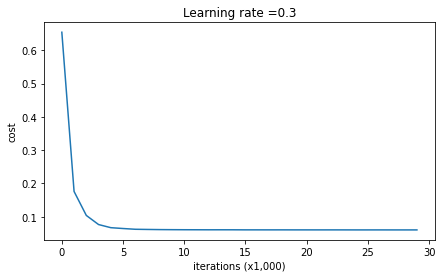

In [68]:
# train NN
parameters = model(train_X, train_Y, keep_prob = 0.86, learning_rate = 0.3)


In [69]:
# Evaluate accuracy

print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

On the train set:
Accuracy: 0.9289099526066351
On the test set:
Accuracy: 0.95


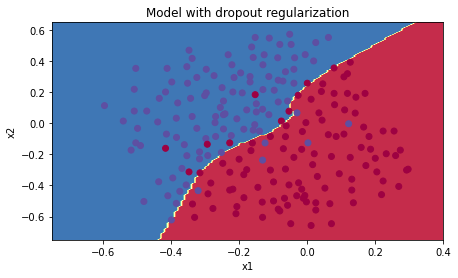

In [70]:
# Plot decision boundary
plt.title("Model with dropout regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)